In [11]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [12]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [13]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [14]:
def multMatrizes(M, us, ps, O = 0, L = 1, T = 0.5):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*(w-us)**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = us*b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = us*c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = us*a*np.ones((1,M-1))
    diagSecundariaB = us*(-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    b = np.matmul(matrizB, np.array(ps)) #Multiplicação de arrays já que houve uma conversão anterior
    psi_c = np.linalg.solve(matrizA, b) #Matlab: x = A\b
    #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [15]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 2000

    xs = np.linspace(-5, L, M)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.05):
        for j in np.arange(0, 20, 0.01):
            psiExato[r][int(j*100)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psii, psiExato):
    A = multMatrizes(M = 200, us = x[0], ps = psii[0:200, y], O = -5, L = 5, T = 20)
    B = multMatrizes(M = 200, us = x[1], ps = A, O = -5, L = 5, T = 20)
    C = multMatrizes(M = 200, us = x[2], ps = B, O = -5, L = 5, T = 20)
    D = multMatrizes(M = 200, us = x[3], ps = C, O = -5, L = 5, T = 20)
    E = multMatrizes(M = 200, us = x[4], ps = D, O = -5, L = 5, T = 20)
        
    return ((np.linalg.norm(np.array(psiExato[0:200, y])-np.array(psii[0:200, y])))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+1])-np.array(A)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+2])-np.array(B)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+3])-np.array(C)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+4])-np.array(D)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+5])-np.array(E)))**2)

In [16]:
import random

psi = np.zeros((200,2000))
psi_f = np.zeros((200,2000))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 200, O = -5, L = 5, T = 20)
psi_g = CrankNicolson(M = 200, O = -5, L = 5, T = 20)
psiExato = ExactSolution(M = 200)

In [17]:
xs = np.linspace(-5,5,200)

Iteração: 1
Mínimo: 0.25088317121382436
Iteração: 1
Mínimo: 0.25088317121382436
Iteração: 2
Mínimo: -0.005238426258953034
Iteração: 3
Mínimo: -0.026746352768808948
Iteração: 2
Mínimo: -0.005238426258953034
Iteração: 3
Mínimo: -0.026746352768808948
Iteração: 4
Mínimo: -0.0058681356494732825
Iteração: 5
Mínimo: -0.0058681356494732825
Iteração: 4
Mínimo: -0.0058681356494732825
Iteração: 5
Mínimo: -0.0058681356494732825
Iteração: 6
Mínimo: 0.04804477281526786
Iteração: 7
Mínimo: -0.023045763471315747
Iteração: 6
Mínimo: 0.04804477281526786
Iteração: 7
Mínimo: -0.023045763471315747
Iteração: 8
Mínimo: 0.008098736210291734
Iteração: 8
Mínimo: 0.008098736210291734
Iteração: 9
Mínimo: 0.002350484266888288
Iteração: 10
Mínimo: 0.002350484266888288
Iteração: 9
Mínimo: 0.002350484266888288
Iteração: 10
Mínimo: 0.002350484266888288
Iteração: 11
Mínimo: 0.06340924203207722
Iteração: 11
Mínimo: 0.06340924203207722
Iteração: 12
Mínimo: -0.019196657598265554
Iteração: 12
Mínimo: -0.019196657598265554


Iteração: 97
Mínimo: -0.00909129563772535
Iteração: 98
Mínimo: -0.00909129563772535
Iteração: 99
Mínimo: -0.00909129563772535
Iteração: 100
Mínimo: -0.00909129563772535
Iteração: 101
Mínimo: -0.00909129563772535
Iteração: 102
Mínimo: -0.00909129563772535
Iteração: 101
Mínimo: -0.00909129563772535
Iteração: 102
Mínimo: -0.00909129563772535
Iteração: 103
Mínimo: -0.019146128053895765
Iteração: 103
Mínimo: -0.019146128053895765
Iteração: 104
Mínimo: -0.014459267069819702
Iteração: 105
Mínimo: -0.014459267069819702
Iteração: 104
Mínimo: -0.014459267069819702
Iteração: 105
Mínimo: -0.014459267069819702
Iteração: 106
Mínimo: -0.014459267069819702
Iteração: 107
Mínimo: -0.014459267069819702
Iteração: 108
Mínimo: -0.014459267069819702
Iteração: 106
Mínimo: -0.014459267069819702
Iteração: 107
Mínimo: -0.014459267069819702
Iteração: 108
Mínimo: -0.014459267069819702
Iteração: 109
Mínimo: -0.014459267069819702
Iteração: 110
Mínimo: -0.014459267069819702
Iteração: 109
Mínimo: -0.014459267069819702

Iteração: 195
Mínimo: 0.04750088705609386
Iteração: 196
Mínimo: 0.04750088705609386
Iteração: 197
Mínimo: 0.04750088705609386
Iteração: 195
Mínimo: 0.04750088705609386
Iteração: 196
Mínimo: 0.04750088705609386
Iteração: 197
Mínimo: 0.04750088705609386
Iteração: 198
Mínimo: 0.05559876630739865
Iteração: 199
Mínimo: 0.05516532133059201
Iteração: 198
Mínimo: 0.05559876630739865
Iteração: 199
Mínimo: 0.05516532133059201
Iteração: 200
Mínimo: 0.06906869220723028
Iteração: 200
Mínimo: 0.06906869220723028
Iteração: 201
Mínimo: 0.0029065504658004025
Iteração: 201
Mínimo: 0.0029065504658004025
Iteração: 202
Mínimo: -0.09291338583742341
Iteração: 202
Mínimo: -0.09291338583742341
Iteração: 203
Mínimo: -0.3141592653589793
Iteração: 203
Mínimo: -0.3141592653589793
Iteração: 204
Mínimo: -0.3141592653589792
Iteração: 204
Mínimo: -0.3141592653589792
Iteração: 205
Mínimo: 0.05137381673819447
Iteração: 205
Mínimo: 0.05137381673819447
Iteração: 206
Mínimo: 0.04271139124343162
Iteração: 206
Mínimo: 0.0427

Iteração: 291
Mínimo: -0.014732351148041292
Iteração: 292
Mínimo: -0.014732351148041292
Iteração: 291
Mínimo: -0.014732351148041292
Iteração: 292
Mínimo: -0.014732351148041292
Iteração: 293
Mínimo: -0.014732351148041292
Iteração: 293
Mínimo: -0.014732351148041292
Iteração: 294
Mínimo: -0.014732351148041292
Iteração: 295
Mínimo: -0.014732351148041292
Iteração: 294
Mínimo: -0.014732351148041292
Iteração: 295
Mínimo: -0.014732351148041292
Iteração: 296
Mínimo: -0.014732351148041292
Iteração: 297
Mínimo: -0.014732351148041292
Iteração: 296
Mínimo: -0.014732351148041292
Iteração: 297
Mínimo: -0.014732351148041292
Iteração: 298
Mínimo: -0.014732351148041292
Iteração: 299
Mínimo: -0.014732351148041292
Iteração: 300
Mínimo: -0.014732351148041292
Iteração: 298
Mínimo: -0.014732351148041292
Iteração: 299
Mínimo: -0.014732351148041292
Iteração: 300
Mínimo: -0.014732351148041292
Iteração: 301
Mínimo: -0.014732351148041292
Iteração: 301
Mínimo: -0.014732351148041292
Iteração: 302
Mínimo: -0.0113190

Iteração: 385
Mínimo: 0.02440332698622321
Iteração: 386
Mínimo: 0.0253094367960987
Iteração: 387
Mínimo: 0.043656459236875944
Iteração: 387
Mínimo: 0.043656459236875944
Iteração: 388
Mínimo: 0.025060357770553685
Iteração: 389
Mínimo: 0.025060357770553685
Iteração: 390
Mínimo: 0.025060357770553685
Iteração: 388
Mínimo: 0.025060357770553685
Iteração: 389
Mínimo: 0.025060357770553685
Iteração: 390
Mínimo: 0.025060357770553685
Iteração: 391
Mínimo: 0.04307549611759975
Iteração: 391
Mínimo: 0.04307549611759975
Iteração: 392
Mínimo: 0.02541028905934828
Iteração: 393
Mínimo: 0.02541028905934828
Iteração: 394
Mínimo: 0.02541028905934828
Iteração: 392
Mínimo: 0.02541028905934828
Iteração: 393
Mínimo: 0.02541028905934828
Iteração: 394
Mínimo: 0.02541028905934828
Iteração: 395
Mínimo: 0.04362188259647085
Iteração: 395
Mínimo: 0.04362188259647085
Iteração: 396
Mínimo: 0.02575697123635432
Iteração: 397
Mínimo: 0.02575697123635432
Iteração: 398
Mínimo: 0.02575697123635432
Iteração: 396
Mínimo: 0.025

Iteração: 482
Mínimo: -0.005056064257103394
Iteração: 483
Mínimo: -0.005056064257103394
Iteração: 484
Mínimo: -0.027685377259168847
Iteração: 484
Mínimo: -0.027685377259168847
Iteração: 485
Mínimo: -0.06665992238935065
Iteração: 485
Mínimo: -0.06665992238935065
Iteração: 486
Mínimo: -0.10128157529343255
Iteração: 486
Mínimo: -0.10128157529343255
Iteração: 487
Mínimo: -0.3141592653589793
Iteração: 487
Mínimo: -0.3141592653589793
Iteração: 488
Mínimo: -0.3141592653589793
Iteração: 488
Mínimo: -0.3141592653589793
Iteração: 489
Mínimo: 0.3141592653589793
Iteração: 489
Mínimo: 0.3141592653589793
Iteração: 490
Mínimo: 0.3141592653589793
Iteração: 490
Mínimo: 0.3141592653589793
Iteração: 491
Mínimo: 0.16421782360749984
Iteração: 491
Mínimo: 0.16421782360749984
Iteração: 492
Mínimo: 0.01546852923841471
Iteração: 492
Mínimo: 0.01546852923841471
Iteração: 493
Mínimo: -0.015547309799250618
Iteração: 493
Mínimo: -0.015547309799250618
Iteração: 494
Mínimo: -0.00812547174977898
Iteração: 495
Mínimo:

Iteração: 580
Mínimo: 0.03020259379917359
Iteração: 581
Mínimo: 0.03020259379917359
Iteração: 582
Mínimo: 0.03020259379917359
Iteração: 580
Mínimo: 0.03020259379917359
Iteração: 581
Mínimo: 0.03020259379917359
Iteração: 582
Mínimo: 0.03020259379917359
Iteração: 583
Mínimo: 0.03020259379917359
Iteração: 583
Mínimo: 0.03020259379917359
Iteração: 584
Mínimo: 0.042983068599892794
Iteração: 584
Mínimo: 0.042983068599892794
Iteração: 585
Mínimo: 0.0335267572823858
Iteração: 586
Mínimo: 0.0335267572823858
Iteração: 587
Mínimo: 0.0335267572823858
Iteração: 585
Mínimo: 0.0335267572823858
Iteração: 586
Mínimo: 0.0335267572823858
Iteração: 587
Mínimo: 0.0335267572823858
Iteração: 588
Mínimo: 0.0335267572823858
Iteração: 589
Mínimo: 0.0335267572823858
Iteração: 590
Mínimo: 0.0335267572823858
Iteração: 588
Mínimo: 0.0335267572823858
Iteração: 589
Mínimo: 0.0335267572823858
Iteração: 590
Mínimo: 0.0335267572823858
Iteração: 591
Mínimo: 0.0335267572823858
Iteração: 592
Mínimo: 0.0335267572823858
Iter

Iteração: 675
Mínimo: -0.011670211580577794
Iteração: 676
Mínimo: -0.011670211580577794
Iteração: 677
Mínimo: -0.011670211580577794
Iteração: 678
Mínimo: -0.011670211580577794
Iteração: 679
Mínimo: -0.011670211580577794
Iteração: 680
Mínimo: -0.011670211580577794
Iteração: 678
Mínimo: -0.011670211580577794
Iteração: 679
Mínimo: -0.011670211580577794
Iteração: 680
Mínimo: -0.011670211580577794
Iteração: 681
Mínimo: -0.011670211580577794
Iteração: 682
Mínimo: -0.011670211580577794
Iteração: 683
Mínimo: -0.011670211580577794
Iteração: 681
Mínimo: -0.011670211580577794
Iteração: 682
Mínimo: -0.011670211580577794
Iteração: 683
Mínimo: -0.011670211580577794
Iteração: 684
Mínimo: -0.020502182495786093
Iteração: 685
Mínimo: -0.020502182495786093
Iteração: 684
Mínimo: -0.020502182495786093
Iteração: 685
Mínimo: -0.020502182495786093
Iteração: 686
Mínimo: -0.014938736629744367
Iteração: 687
Mínimo: -0.014938736629744367
Iteração: 688
Mínimo: -0.014938736629744367
Iteração: 686
Mínimo: -0.0149387

Iteração: 771
Mínimo: 0.026602708848189726
Iteração: 772
Mínimo: 0.026602708848189726
Iteração: 773
Mínimo: 0.026602708848189726
Iteração: 771
Mínimo: 0.026602708848189726
Iteração: 772
Mínimo: 0.026602708848189726
Iteração: 773
Mínimo: 0.026602708848189726
Iteração: 774
Mínimo: 0.026602708848189726
Iteração: 775
Mínimo: 0.026602708848189726
Iteração: 774
Mínimo: 0.026602708848189726
Iteração: 775
Mínimo: 0.026602708848189726
Iteração: 776
Mínimo: 0.037271690464717455
Iteração: 776
Mínimo: 0.037271690464717455
Iteração: 777
Mínimo: 0.03129055236457638
Iteração: 778
Mínimo: 0.03129055236457638
Iteração: 779
Mínimo: 0.03129055236457638
Iteração: 777
Mínimo: 0.03129055236457638
Iteração: 778
Mínimo: 0.03129055236457638
Iteração: 779
Mínimo: 0.03129055236457638
Iteração: 780
Mínimo: 0.03129055236457638
Iteração: 781
Mínimo: 0.03129055236457638
Iteração: 782
Mínimo: 0.03129055236457638
Iteração: 780
Mínimo: 0.03129055236457638
Iteração: 781
Mínimo: 0.03129055236457638
Iteração: 782
Mínimo: 

Iteração: 867
Mínimo: -0.007558469871512259
Iteração: 868
Mínimo: -0.007558469871512259
Iteração: 869
Mínimo: -0.007558469871512259
Iteração: 867
Mínimo: -0.007558469871512259
Iteração: 868
Mínimo: -0.007558469871512259
Iteração: 869
Mínimo: -0.007558469871512259
Iteração: 870
Mínimo: -0.002289523726980021
Iteração: 871
Mínimo: -0.002289523726980021
Iteração: 872
Mínimo: -0.002289523726980021
Iteração: 870
Mínimo: -0.002289523726980021
Iteração: 871
Mínimo: -0.002289523726980021
Iteração: 872
Mínimo: -0.002289523726980021
Iteração: 873
Mínimo: -0.02530849518456373
Iteração: 873
Mínimo: -0.02530849518456373
Iteração: 874
Mínimo: -0.06687673474685085
Iteração: 874
Mínimo: -0.06687673474685085
Iteração: 875
Mínimo: -0.09600845180711855
Iteração: 875
Mínimo: -0.09600845180711855
Iteração: 876
Mínimo: -0.3141592653589793
Iteração: 876
Mínimo: -0.3141592653589793
Iteração: 877
Mínimo: -0.3141592653589793
Iteração: 877
Mínimo: -0.3141592653589793
Iteração: 878
Mínimo: 0.3141592653589793
Itera

Iteração: 962
Mínimo: 0.01841890977028075
Iteração: 962
Mínimo: 0.01841890977028075
Iteração: 963
Mínimo: 0.013493609220253236
Iteração: 964
Mínimo: 0.013493609220253236
Iteração: 965
Mínimo: 0.013493609220253236
Iteração: 963
Mínimo: 0.013493609220253236
Iteração: 964
Mínimo: 0.013493609220253236
Iteração: 965
Mínimo: 0.013493609220253236
Iteração: 966
Mínimo: 0.013493609220253236
Iteração: 967
Mínimo: 0.013493609220253236
Iteração: 966
Mínimo: 0.013493609220253236
Iteração: 967
Mínimo: 0.013493609220253236
Iteração: 968
Mínimo: 0.02663539780486833
Iteração: 968
Mínimo: 0.02663539780486833
Iteração: 969
Mínimo: 0.019440304184581623
Iteração: 970
Mínimo: 0.019440304184581623
Iteração: 971
Mínimo: 0.019440304184581623
Iteração: 972
Mínimo: 0.019440304184581623
Iteração: 969
Mínimo: 0.019440304184581623
Iteração: 970
Mínimo: 0.019440304184581623
Iteração: 971
Mínimo: 0.019440304184581623
Iteração: 972
Mínimo: 0.019440304184581623
Iteração: 973
Mínimo: 0.03730143094607181
Iteração: 973
Mí

Iteração: 1056
Mínimo: 0.006023339693290812
Iteração: 1057
Mínimo: 0.006023339693290812
Iteração: 1058
Mínimo: 0.006023339693290812
Iteração: 1059
Mínimo: 0.006023339693290812
Iteração: 1060
Mínimo: 0.006023339693290812
Iteração: 1061
Mínimo: 0.006023339693290812
Iteração: 1059
Mínimo: 0.006023339693290812
Iteração: 1060
Mínimo: 0.006023339693290812
Iteração: 1061
Mínimo: 0.006023339693290812
Iteração: 1062
Mínimo: 0.006023339693290812
Iteração: 1062
Mínimo: 0.006023339693290812
Iteração: 1063
Mínimo: -0.0006473262300722943
Iteração: 1064
Mínimo: -0.0006473262300722943
Iteração: 1065
Mínimo: -0.0006473262300722943
Iteração: 1063
Mínimo: -0.0006473262300722943
Iteração: 1064
Mínimo: -0.0006473262300722943
Iteração: 1065
Mínimo: -0.0006473262300722943
Iteração: 1066
Mínimo: -0.0006473262300722943
Iteração: 1067
Mínimo: -0.0006473262300722943
Iteração: 1068
Mínimo: -0.0006473262300722943
Iteração: 1066
Mínimo: -0.0006473262300722943
Iteração: 1067
Mínimo: -0.0006473262300722943
Iteração: 

Iteração: 1149
Mínimo: 0.017410915777974132
Iteração: 1150
Mínimo: 0.017410915777974132
Iteração: 1151
Mínimo: 0.017410915777974132
Iteração: 1152
Mínimo: 0.017410915777974132
Iteração: 1153
Mínimo: 0.017410915777974132
Iteração: 1154
Mínimo: 0.017410915777974132
Iteração: 1153
Mínimo: 0.017410915777974132
Iteração: 1154
Mínimo: 0.017410915777974132
Iteração: 1155
Mínimo: 0.023447704056212743
Iteração: 1156
Mínimo: 0.023447704056212743
Iteração: 1157
Mínimo: 0.023447704056212743
Iteração: 1158
Mínimo: 0.023447704056212743
Iteração: 1159
Mínimo: 0.023447704056212743
Iteração: 1155
Mínimo: 0.023447704056212743
Iteração: 1156
Mínimo: 0.023447704056212743
Iteração: 1157
Mínimo: 0.023447704056212743
Iteração: 1158
Mínimo: 0.023447704056212743
Iteração: 1159
Mínimo: 0.023447704056212743
Iteração: 1160
Mínimo: 0.023447704056212743
Iteração: 1161
Mínimo: 0.024047386387297948
Iteração: 1160
Mínimo: 0.023447704056212743
Iteração: 1161
Mínimo: 0.024047386387297948
Iteração: 1162
Mínimo: 0.0315229

Iteração: 1245
Mínimo: 0.004919543994502008
Iteração: 1246
Mínimo: 0.004919543994502008
Iteração: 1247
Mínimo: 0.004919543994502008
Iteração: 1245
Mínimo: 0.004919543994502008
Iteração: 1246
Mínimo: 0.004919543994502008
Iteração: 1247
Mínimo: 0.004919543994502008
Iteração: 1248
Mínimo: 0.002419173306707938
Iteração: 1249
Mínimo: 0.002419173306707938
Iteração: 1250
Mínimo: 0.002419173306707938
Iteração: 1251
Mínimo: 0.002419173306707938
Iteração: 1248
Mínimo: 0.002419173306707938
Iteração: 1249
Mínimo: 0.002419173306707938
Iteração: 1250
Mínimo: 0.002419173306707938
Iteração: 1251
Mínimo: 0.002419173306707938
Iteração: 1252
Mínimo: -0.0009108332246235817
Iteração: 1253
Mínimo: -0.0009108332246235817
Iteração: 1254
Mínimo: -0.0009108332246235817
Iteração: 1255
Mínimo: -0.0009108332246235817
Iteração: 1252
Mínimo: -0.0009108332246235817
Iteração: 1253
Mínimo: -0.0009108332246235817
Iteração: 1254
Mínimo: -0.0009108332246235817
Iteração: 1255
Mínimo: -0.0009108332246235817
Iteração: 1256
M

Iteração: 1336
Mínimo: 0.00361551827363463
Iteração: 1337
Mínimo: 0.00361551827363463
Iteração: 1338
Mínimo: 0.00361551827363463
Iteração: 1339
Mínimo: 0.00361551827363463
Iteração: 1340
Mínimo: 0.00361551827363463
Iteração: 1341
Mínimo: 0.00361551827363463
Iteração: 1341
Mínimo: 0.00361551827363463
Iteração: 1342
Mínimo: 0.010209148660679674
Iteração: 1343
Mínimo: 0.010209148660679674
Iteração: 1344
Mínimo: 0.010209148660679674
Iteração: 1345
Mínimo: 0.010209148660679674
Iteração: 1346
Mínimo: 0.010209148660679674
Iteração: 1342
Mínimo: 0.010209148660679674
Iteração: 1343
Mínimo: 0.010209148660679674
Iteração: 1344
Mínimo: 0.010209148660679674
Iteração: 1345
Mínimo: 0.010209148660679674
Iteração: 1346
Mínimo: 0.010209148660679674
Iteração: 1347
Mínimo: 0.010209148660679674
Iteração: 1348
Mínimo: 0.010209148660679674
Iteração: 1349
Mínimo: 0.010209148660679674
Iteração: 1350
Mínimo: 0.010209148660679674
Iteração: 1347
Mínimo: 0.010209148660679674
Iteração: 1348
Mínimo: 0.01020914866067

Iteração: 1432
Mínimo: 0.02360010425113996
Iteração: 1433
Mínimo: 0.02360010425113996
Iteração: 1434
Mínimo: 0.02360010425113996
Iteração: 1435
Mínimo: 0.02360010425113996
Iteração: 1436
Mínimo: 0.020575760635874338
Iteração: 1437
Mínimo: 0.020575760635874338
Iteração: 1438
Mínimo: 0.020575760635874338
Iteração: 1439
Mínimo: 0.020575760635874338
Iteração: 1436
Mínimo: 0.020575760635874338
Iteração: 1437
Mínimo: 0.020575760635874338
Iteração: 1438
Mínimo: 0.020575760635874338
Iteração: 1439
Mínimo: 0.020575760635874338
Iteração: 1440
Mínimo: 0.020575760635874338
Iteração: 1441
Mínimo: 0.01657277298970221
Iteração: 1440
Mínimo: 0.020575760635874338
Iteração: 1441
Mínimo: 0.01657277298970221
Iteração: 1442
Mínimo: 0.01657277298970221
Iteração: 1443
Mínimo: 0.01657277298970221
Iteração: 1444
Mínimo: 0.01657277298970221
Iteração: 1445
Mínimo: 0.01657277298970221
Iteração: 1446
Mínimo: 0.01657277298970221
Iteração: 1442
Mínimo: 0.01657277298970221
Iteração: 1443
Mínimo: 0.01657277298970221
I

Iteração: 1526
Mínimo: -0.006602989491148205
Iteração: 1527
Mínimo: -0.006602989491148205
Iteração: 1528
Mínimo: -0.006602989491148205
Iteração: 1529
Mínimo: -0.006602989491148205
Iteração: 1526
Mínimo: -0.006602989491148205
Iteração: 1527
Mínimo: -0.006602989491148205
Iteração: 1528
Mínimo: -0.006602989491148205
Iteração: 1529
Mínimo: -0.006602989491148205
Iteração: 1530
Mínimo: -0.006602989491148205
Iteração: 1531
Mínimo: -0.006602989491148205
Iteração: 1532
Mínimo: -0.006602989491148205
Iteração: 1530
Mínimo: -0.006602989491148205
Iteração: 1531
Mínimo: -0.006602989491148205
Iteração: 1532
Mínimo: -0.006602989491148205
Iteração: 1533
Mínimo: -0.0007020077326879634
Iteração: 1534
Mínimo: -0.0007020077326879634
Iteração: 1535
Mínimo: -0.0007020077326879634
Iteração: 1536
Mínimo: -0.0007020077326879634
Iteração: 1533
Mínimo: -0.0007020077326879634
Iteração: 1534
Mínimo: -0.0007020077326879634
Iteração: 1535
Mínimo: -0.0007020077326879634
Iteração: 1536
Mínimo: -0.0007020077326879634
It

Iteração: 1619
Mínimo: 0.022729833203246334
Iteração: 1620
Mínimo: -0.0016506895596935488
Iteração: 1621
Mínimo: 0.01334661836962895
Iteração: 1622
Mínimo: 0.01334661836962895
Iteração: 1623
Mínimo: 0.01334661836962895
Iteração: 1624
Mínimo: 0.01334661836962895
Iteração: 1621
Mínimo: 0.01334661836962895
Iteração: 1622
Mínimo: 0.01334661836962895
Iteração: 1623
Mínimo: 0.01334661836962895
Iteração: 1624
Mínimo: 0.01334661836962895
Iteração: 1625
Mínimo: 0.01334661836962895
Iteração: 1625
Mínimo: 0.01334661836962895
Iteração: 1626
Mínimo: 0.03112996531755136
Iteração: 1626
Mínimo: 0.03112996531755136
Iteração: 1627
Mínimo: -0.04910381116226004
Iteração: 1627
Mínimo: -0.04910381116226004
Iteração: 1628
Mínimo: -0.05460363877957071
Iteração: 1628
Mínimo: -0.05460363877957071
Iteração: 1629
Mínimo: -0.3034913803990208
Iteração: 1629
Mínimo: -0.3034913803990208
Iteração: 1630
Mínimo: -0.31415926535897915
Iteração: 1630
Mínimo: -0.31415926535897915
Iteração: 1631
Mínimo: 0.3141592653589793
It

Iteração: 1715
Mínimo: 0.0005235395746633689
Iteração: 1716
Mínimo: 0.0005235395746633689
Iteração: 1717
Mínimo: 0.0005235395746633689
Iteração: 1718
Mínimo: 0.0005235395746633689
Iteração: 1715
Mínimo: 0.0005235395746633689
Iteração: 1716
Mínimo: 0.0005235395746633689
Iteração: 1717
Mínimo: 0.0005235395746633689
Iteração: 1718
Mínimo: 0.0005235395746633689
Iteração: 1719
Mínimo: -0.00036090394683626487
Iteração: 1720
Mínimo: -0.00036090394683626487
Iteração: 1721
Mínimo: -0.00036090394683626487
Iteração: 1722
Mínimo: -0.00036090394683626487
Iteração: 1719
Mínimo: -0.00036090394683626487
Iteração: 1720
Mínimo: -0.00036090394683626487
Iteração: 1721
Mínimo: -0.00036090394683626487
Iteração: 1722
Mínimo: -0.00036090394683626487
Iteração: 1723
Mínimo: -0.00036090394683626487
Iteração: 1724
Mínimo: -0.00036090394683626487
Iteração: 1725
Mínimo: -0.00036090394683626487
Iteração: 1723
Mínimo: -0.00036090394683626487
Iteração: 1724
Mínimo: -0.00036090394683626487
Iteração: 1725
Mínimo: -0.000

Iteração: 1808
Mínimo: 0.3006765356213604
Iteração: 1809
Mínimo: 0.08325228832088145
Iteração: 1809
Mínimo: 0.08325228832088145
Iteração: 1810
Mínimo: -0.0035968981562232924
Iteração: 1810
Mínimo: -0.0035968981562232924
Iteração: 1811
Mínimo: 0.029506174091702128
Iteração: 1811
Mínimo: 0.029506174091702128
Iteração: 1812
Mínimo: 0.022205815801617863
Iteração: 1813
Mínimo: 0.022205815801617863
Iteração: 1814
Mínimo: 0.022205815801617863
Iteração: 1812
Mínimo: 0.022205815801617863
Iteração: 1813
Mínimo: 0.022205815801617863
Iteração: 1814
Mínimo: 0.022205815801617863
Iteração: 1815
Mínimo: 0.03579265799761604
Iteração: 1815
Mínimo: 0.03579265799761604
Iteração: 1816
Mínimo: 0.02728283753354374
Iteração: 1817
Mínimo: 0.02728283753354374
Iteração: 1818
Mínimo: 0.02728283753354374
Iteração: 1819
Mínimo: 0.02728283753354374
Iteração: 1816
Mínimo: 0.02728283753354374
Iteração: 1817
Mínimo: 0.02728283753354374
Iteração: 1818
Mínimo: 0.02728283753354374
Iteração: 1819
Mínimo: 0.0272828375335437

Iteração: 1902
Mínimo: -0.08514995382016675
Iteração: 1902
Mínimo: -0.08514995382016675
Iteração: 1903
Mínimo: -0.11786173538391471
Iteração: 1903
Mínimo: -0.11786173538391471
Iteração: 1904
Mínimo: -0.31415926535897926
Iteração: 1904
Mínimo: -0.31415926535897926
Iteração: 1905
Mínimo: -0.3141592653589793
Iteração: 1905
Mínimo: -0.3141592653589793
Iteração: 1906
Mínimo: 0.3141592653589793
Iteração: 1906
Mínimo: 0.3141592653589793
Iteração: 1907
Mínimo: 0.3141592653589793
Iteração: 1907
Mínimo: 0.3141592653589793
Iteração: 1908
Mínimo: 0.14846382639367295
Iteração: 1908
Mínimo: 0.14846382639367295
Iteração: 1909
Mínimo: 0.005953914956844421
Iteração: 1910
Mínimo: -0.02416868057015846
Iteração: 1909
Mínimo: 0.005953914956844421
Iteração: 1910
Mínimo: -0.02416868057015846
Iteração: 1911
Mínimo: -0.01531892913800104
Iteração: 1912
Mínimo: -0.01531892913800104
Iteração: 1913
Mínimo: -0.01531892913800104
Iteração: 1914
Mínimo: -0.01531892913800104
Iteração: 1915
Mínimo: -0.01531892913800104


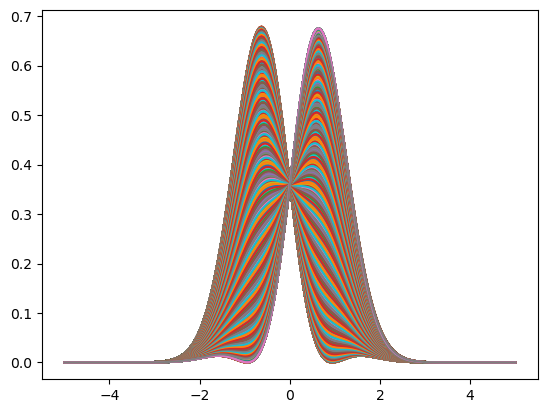

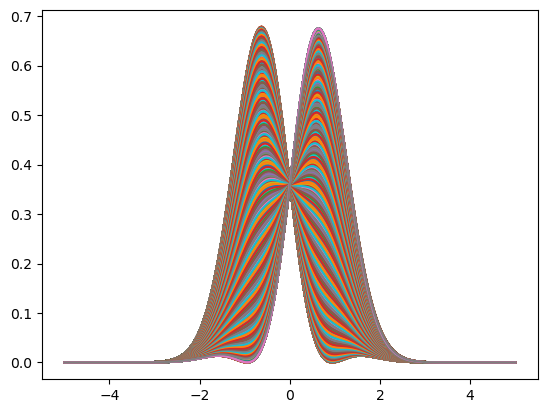

In [18]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,200)
minimo = np.zeros((1, 2000)).astype(complex)
bnds = ((-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi))

while tempo < 1994:
    #print(u1)
    plt.plot(xs, np.absolute(psi[0:200, tempo])**2)
    plt.plot(xs, np.absolute(psi_g[0:200, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi_g, psiExato), bounds = bnds, method='SLSQP')
    print(f"Iteração: {tempo+1}")
    print(f"Mínimo: {u2.x[0]}")
    #minimo[0][tempo] = (u2.x[0])
    #print("-------------")
    #print(f"{psi[0:200, tempo+1]}")
    psi_g[0:200, tempo+1] = multMatrizes(M = 200, us = u2.x[0], ps = psi_g[0:200, tempo], O = -5, L = 5, T = 20)
    #print("-------------")
    #print(f"{psi[0:200, tempo+1]}")
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])

tempoFinal = time.time() - tempoInicial
print(tempoFinal)

In [19]:
print(psi_g[0:200,1999])
print("---------------")
print(psiExato[0:200,1999])
print("---------------")
print(psi[0:200,1999])
print("--------------")
print(psi_g[0:200,1999] - psi[0:200,1999])
print("--------------")
print(psi_g - psi)

[-3.69227736e-06+9.94341715e-07j -7.06984415e-06+2.93571425e-06j
 -1.01804611e-05+4.00089890e-06j -1.46640563e-05+4.75627697e-06j
 -2.09096709e-05+6.46172640e-06j -2.73125548e-05+8.38367484e-06j
 -3.42674502e-05+1.09906273e-05j -4.36347761e-05+1.39599280e-05j
 -5.60856055e-05+1.67581718e-05j -7.09499769e-05+2.09144109e-05j
 -8.79386022e-05+2.65333413e-05j -1.08343993e-04+3.29518774e-05j
 -1.33647438e-04+4.12370178e-05j -1.64163170e-04+5.02327844e-05j
 -2.01192665e-04+6.01863602e-05j -2.46348898e-04+7.35973248e-05j
 -3.00121546e-04+9.01029109e-05j -3.63755008e-04+1.09325364e-04j
 -4.40158777e-04+1.33247326e-04j -5.32029660e-04+1.61283953e-04j
 -6.40746923e-04+1.94445089e-04j -7.68369667e-04+2.35001391e-04j
 -9.19081904e-04+2.83073636e-04j -1.09705522e-03+3.39330887e-04j
 -1.30587486e-03+4.05704010e-04j -1.55078098e-03+4.83190539e-04j
 -1.83641086e-03+5.74461677e-04j -2.16791622e-03+6.80720421e-04j
 -2.55149334e-03+8.03027701e-04j -2.99329407e-03+9.45041430e-04j
 -3.50121551e-03+1.109423

[-3.69227736e-06+9.94341715e-07j -7.06984415e-06+2.93571425e-06j
 -1.01804611e-05+4.00089890e-06j -1.46640563e-05+4.75627697e-06j
 -2.09096709e-05+6.46172640e-06j -2.73125548e-05+8.38367484e-06j
 -3.42674502e-05+1.09906273e-05j -4.36347761e-05+1.39599280e-05j
 -5.60856055e-05+1.67581718e-05j -7.09499769e-05+2.09144109e-05j
 -8.79386022e-05+2.65333413e-05j -1.08343993e-04+3.29518774e-05j
 -1.33647438e-04+4.12370178e-05j -1.64163170e-04+5.02327844e-05j
 -2.01192665e-04+6.01863602e-05j -2.46348898e-04+7.35973248e-05j
 -3.00121546e-04+9.01029109e-05j -3.63755008e-04+1.09325364e-04j
 -4.40158777e-04+1.33247326e-04j -5.32029660e-04+1.61283953e-04j
 -6.40746923e-04+1.94445089e-04j -7.68369667e-04+2.35001391e-04j
 -9.19081904e-04+2.83073636e-04j -1.09705522e-03+3.39330887e-04j
 -1.30587486e-03+4.05704010e-04j -1.55078098e-03+4.83190539e-04j
 -1.83641086e-03+5.74461677e-04j -2.16791622e-03+6.80720421e-04j
 -2.55149334e-03+8.03027701e-04j -2.99329407e-03+9.45041430e-04j
 -3.50121551e-03+1.109423

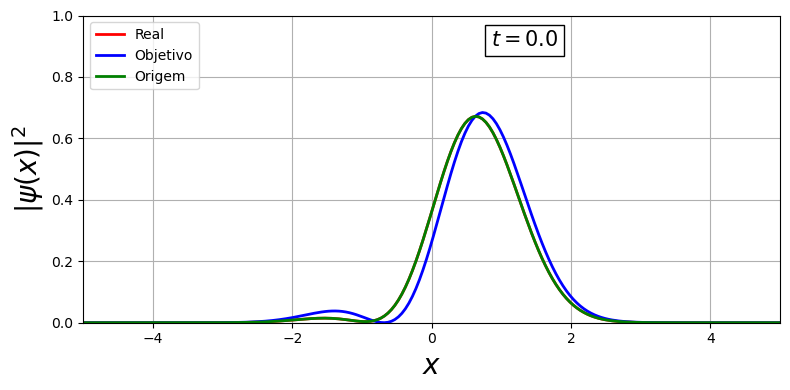

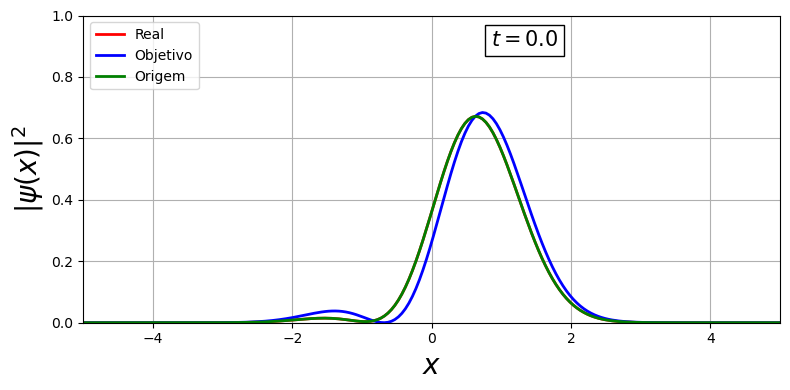

In [20]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,200)
    ln1.set_data(xs, np.absolute(psi_g[0:200,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:200,i-1])**2)
    ln3.set_data(xs, np.absolute(psi[0:200,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Real')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Objetivo')
ln3, = plt.plot([], [], 'g-', lw=2, markersize=8, label='Origem')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=2000, interval=2000)
ani.save('200x200_bounds.gif',writer='pillow',fps=20,dpi=100)